In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import math

In [3]:
tr_dset = torchvision.datasets.FashionMNIST('tr',train=True,download=True)
te_dset = torchvision.datasets.FashionMNIST('te',train=False,download=True)

Extracting tr/FashionMNIST/raw/train-images-idx3-ubyte.gz to tr/FashionMNIST/raw


Extracting tr/FashionMNIST/raw/train-labels-idx1-ubyte.gz to tr/FashionMNIST/raw



Extracting tr/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to tr/FashionMNIST/raw


Extracting tr/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to tr/FashionMNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting te/FashionMNIST/raw/train-images-idx3-ubyte.gz to te/FashionMNIST/raw


Extracting te/FashionMNIST/raw/train-labels-idx1-ubyte.gz to te/FashionMNIST/raw


Extracting te/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to te/FashionMNIST/raw


Extracting te/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to te/FashionMNIST/raw
Processing...
Done!


In [4]:
tr_img_mean = np.mean(np.mean(tr_dset.data.numpy(),axis=(1,2)))/256
tr_img_std = np.std(np.std(tr_dset.data.numpy(),axis=(1,2)))/256
te_img_mean = np.mean(np.mean(te_dset.data.numpy(),axis=(1,2)))/256
te_img_std = np.std(np.std(te_dset.data.numpy(),axis=(1,2)))/256

In [5]:
tr_transform = transforms.Compose([
    transforms.RandomCrop(28,padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(tr_img_mean),std=(tr_img_std))
    
])
te_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(te_img_mean),std=(te_img_std))
])

In [6]:
tr_dset = torchvision.datasets.FashionMNIST('tr',train=True,download=False,
                                            transform=tr_transform)
te_dset = torchvision.datasets.FashionMNIST('te',train=False,download=False,
                                           transform=te_transform)

In [7]:
tr_loader = torch.utils.data.DataLoader(tr_dset,batch_size = 128,shuffle=True,drop_last=True)
te_loader = torch.utils.data.DataLoader(te_dset,batch_size = 128,shuffle = True,drop_last=True)

In [38]:
class VGG(nn.Module):
    def __init__(self, layers_):
        super(VGG, self).__init__()
        
        self.layers_ = layers_
        self.fc_layers_ = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        out = self.layers_(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers_(out)
        return out


def make_blocks(cfg, batch_norm=False,RGB=False):
    blocks = []
    if RGB:
        init_ch = 3
    else:
        init_ch = 1
    
    for m in cfg:
        if m == 'M':
            blocks += [nn.MaxPool2d(2,2)]
        elif m == '1x1':
            conv2d = nn.Conv2d(init_ch,init_ch,1,stride=1)
            blocks += [conv2d,nn.ReLU(inplace=True)]
        else:
            conv2d = nn.Conv2d(init_ch, m,kernel_size=3,padding=1)
            if batch_norm:
                blocks += [conv2d, nn.BatchNorm2d(m), nn.ReLU(inplace=True)]
            else:
                blocks += [conv2d, nn.ReLU(inplace=True)]
            init_ch = m
    print(blocks)
    return nn.Sequential(*blocks)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'C': [64, 64, 'M', 128, 128, 'M', 256, 256, '1x1', 'M', 512, 512, '1x1', 'M', 512, 512, '1x1', 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'small': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M']
}

rgb = False

def vgg11():
    return VGG(make_blocks(cfg['A'],batch_norm=True,RGB=rgb))


def vgg11_bn():
    return VGG(make_blocks(cfg['A'], batch_norm=True,RGB=rgb))


def vgg13():
    return VGG(make_blocks(cfg['B'],RGB=rgb))


def vgg13_bn():
    return VGG(make_blocks(cfg['B'], batch_norm=True,RGB=rgb))

def vgg16_1x1():
    return VGG(make_blocks(cfg['C'],batch_norm=False,RGB=rgb))

def vgg16():
    return VGG(make_blocks(cfg['D'],batch_norm=False,RGB=rgb))


def vgg16_bn():
    return VGG(make_blocks(cfg['D'], batch_norm=True,RGB=rgb))


def vgg19():
    return VGG(make_blocks(cfg['E'],RGB=rgb))


def vgg19_bn():
    return VGG(make_blocks(cfg['E'], batch_norm=True,RGB=rgb))

def vgg_small():
    return VGG(make_blocks(cfg['small'],batch_norm=False,RGB=rgb))

In [36]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model = Simple_CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters())

In [22]:
epoch = 30
batch_size = 128
cnn_loss_arr = []
vgg_loss_arr = []
def train(loss_arr,model,add_axis=False):
    for i in range(epoch):
        epoch_loss = 0
        correct = 0
        total = 0
        for j,[image,label] in enumerate(tr_loader):
            model.train()
            if add_axis:
                x = image.unsqueeze(1).to(device)
            else:
                x = image.to(device)
            y = label.to(device)
            optimizer.zero_grad()
            out = model.forward(x)
            _,output_ind = torch.max(out,1)
            loss = loss_func(out,y)
            epoch_loss += loss
            loss.backward()
            optimizer.step()
            total += y.size()[0]
            correct += (output_ind == y).sum().float()

        loss_arr.append(epoch_loss)
        with torch.no_grad():
            val_correct = 0
            val_total = 0
            for k,[image,label] in enumerate(te_loader):
                if add_axis:
                    x = image.unsqueeze(1).to(device)
                else:
                    x = image.to(device)
                y = label.to(device)
                model.eval()
                out = model.forward(x)
                _,output_ind = torch.max(out,1)
                val_loss = loss_func(out,y)
                val_total += y.size()[0]
                val_correct += (output_ind == y).sum().float()
        print("epoch {} || train loss : {:.4f} || train acc : {:.4f} || test loss : {:.4f} || test acc : {:.4f}".format(i+1,
        loss,correct/total*100,val_loss,val_correct/val_total*100))

In [20]:
train(loss_arr,cnn_model)

epoch 1 || train loss : 0.4935 || train acc : 73.0335 || test loss : 0.5143 || test acc : 81.0096
epoch 2 || train loss : 0.3367 || train acc : 81.8693 || test loss : 0.5401 || test acc : 84.6454
epoch 3 || train loss : 0.6031 || train acc : 84.7539 || test loss : 0.3415 || test acc : 86.7688
epoch 4 || train loss : 0.4695 || train acc : 86.1495 || test loss : 0.2945 || test acc : 87.4499
epoch 5 || train loss : 0.2755 || train acc : 86.9241 || test loss : 0.4263 || test acc : 88.4716
epoch 6 || train loss : 0.3495 || train acc : 87.4432 || test loss : 0.2563 || test acc : 88.1811
epoch 7 || train loss : 0.2889 || train acc : 88.0542 || test loss : 0.2603 || test acc : 88.8221
epoch 8 || train loss : 0.2753 || train acc : 88.1828 || test loss : 0.3195 || test acc : 89.7236
epoch 9 || train loss : 0.1998 || train acc : 88.7119 || test loss : 0.3673 || test acc : 89.9539
epoch 10 || train loss : 0.4114 || train acc : 89.1226 || test loss : 0.2916 || test acc : 89.8337
epoch 11 || train l

In [39]:
vgg_model = vgg_small().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters())
train(vgg_loss_arr,vgg_model,add_axis=False)

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

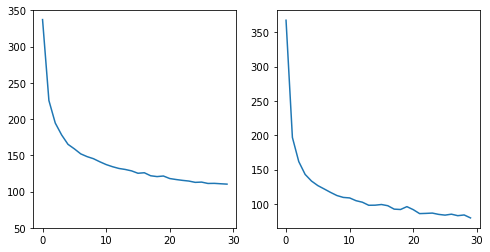

In [48]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(loss_arr[:30])
ax[0].set_ylim(50,350)
ax[1].set_ylim(50,350)
ax[1].plot(vgg_loss_arr)
plt.show()